In [1]:
import pickle
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [2]:
filename = "unknown_image_28x28_with_label_caseA.pkl"
with open(filename, 'rb') as f:
    image_with_label = pickle.load(f) 

print(image_with_label.keys())

dict_keys(['image', 'label'])


## Principle components in the data with annotated clusters

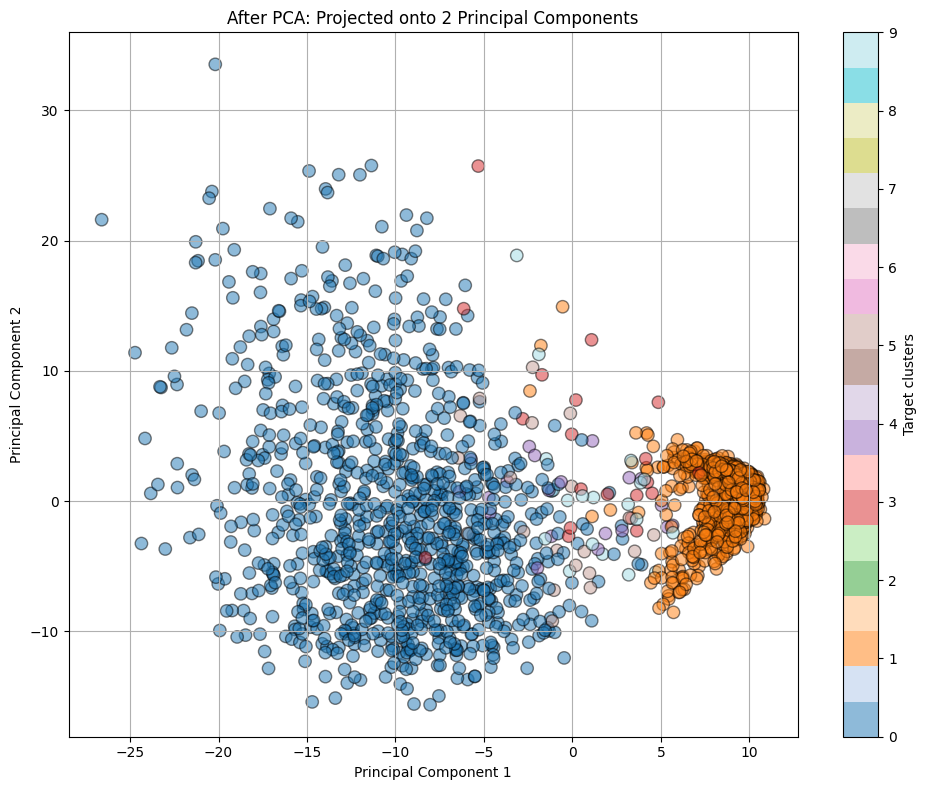

In [3]:
scaler = StandardScaler()
image_2d_scaled = scaler.fit_transform(image_with_label["image"])

pca = PCA(n_components=2)
data_array_pca = pca.fit_transform(image_2d_scaled)   


plt.figure(figsize=(10, 8))

plt.scatter(data_array_pca[:, 0], data_array_pca[:, 1], c=image_with_label["label"], cmap="tab20", edgecolor='k', s=80, alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('After PCA: Projected onto 2 Principal Components') 

plt.colorbar(label='Target clusters')
plt.grid()
plt.tight_layout()

## Candidate clustering algorithms

1. K-mean algorithm
2. Gaussian mixture model
3. DBSCAN

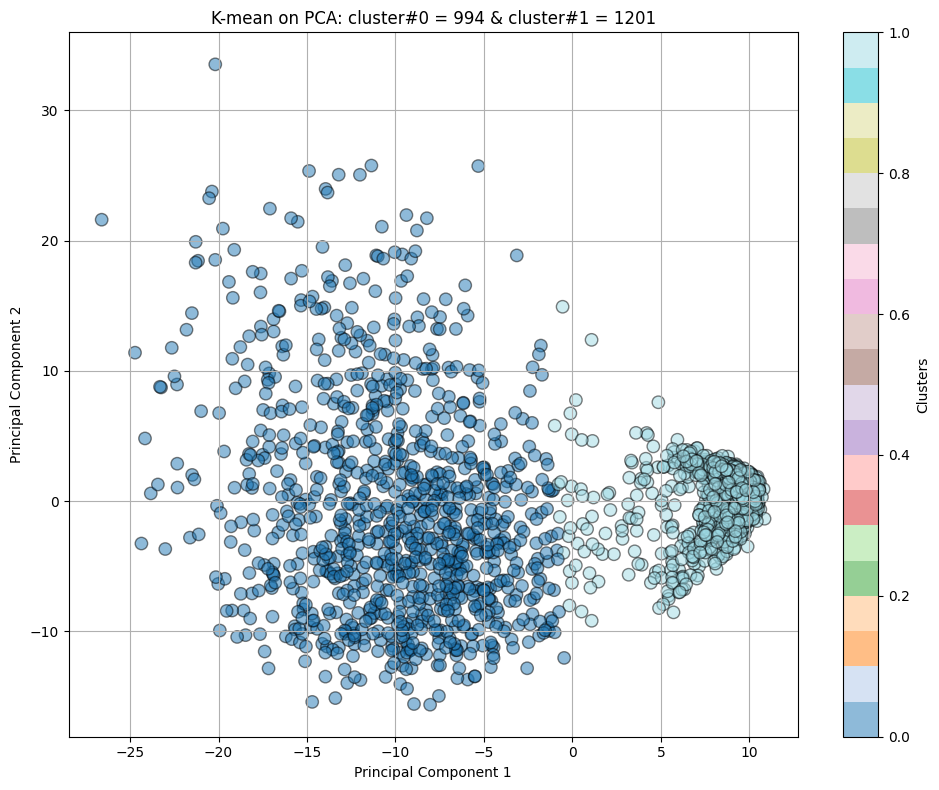

In [9]:
# K-mean algorithm
from sklearn.cluster import KMeans
 
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(data_array_pca)
predicted_cluster =  kmeans.labels_

plt.figure(figsize=(10, 8))

plt.scatter(data_array_pca[:, 0], data_array_pca[:, 1],  c=predicted_cluster, edgecolor='k', cmap="tab20", s=80, alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-mean on PCA: cluster#0 = %d & cluster#1 = %d' % (sum(predicted_cluster == 0).item(), sum(predicted_cluster == 1).item()))
 

plt.colorbar(label='Clusters')
plt.grid()
plt.tight_layout()

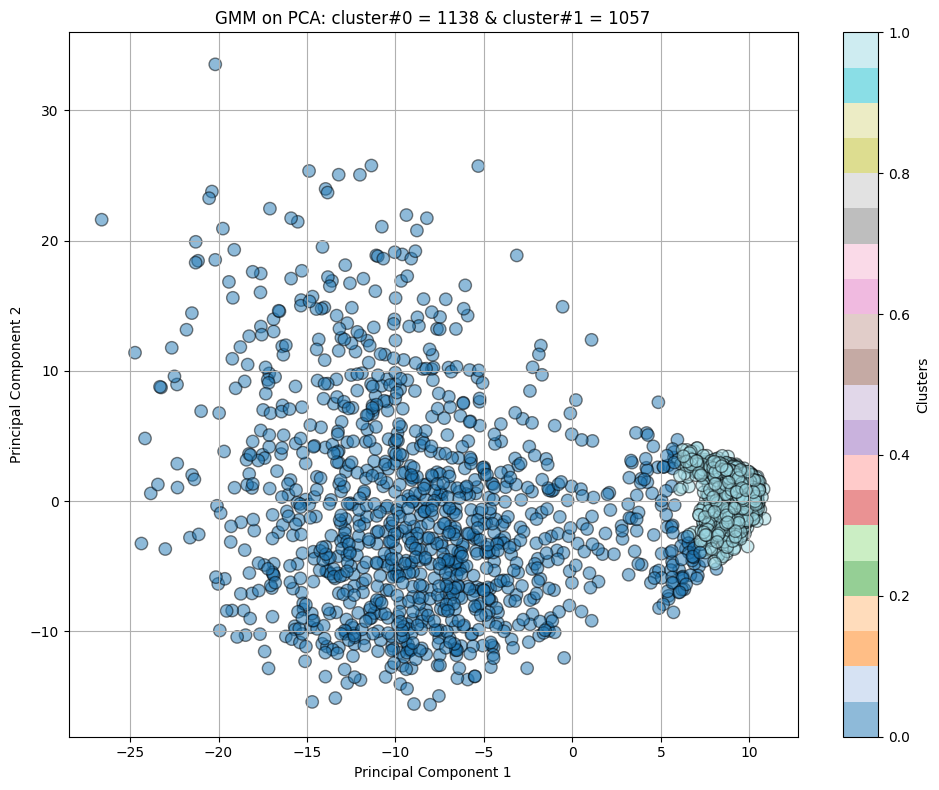

In [8]:
# Gaussian mixture model
from sklearn.mixture import GaussianMixture
X      = data_array_pca
gm = GaussianMixture(n_components=2, random_state=0).fit(X)
predicted_cluster =  gm.predict(X)

plt.figure(figsize=(10, 8))

plt.scatter(data_array_pca[:, 0], data_array_pca[:, 1],  c=predicted_cluster, edgecolor='k', cmap="tab20", s=80, alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('GMM on PCA: cluster#0 = %d & cluster#1 = %d' % (sum(predicted_cluster == 0).item(), sum(predicted_cluster == 1).item()))
 

plt.colorbar(label='Clusters')
plt.grid()
plt.tight_layout()

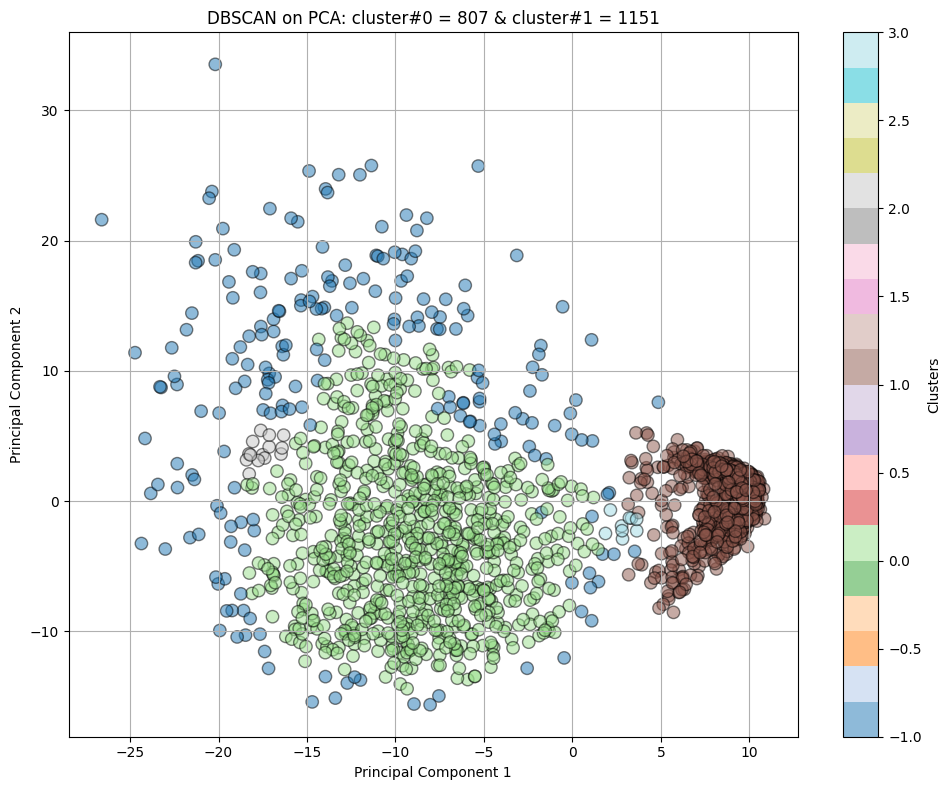

In [7]:
# Gaussian mixture model
from sklearn.cluster import DBSCAN
X      = data_array_pca
dbscan = DBSCAN(eps=1.5, min_samples=10).fit(X)
predicted_cluster =  dbscan.labels_

plt.figure(figsize=(10, 8))

plt.scatter(data_array_pca[:, 0], data_array_pca[:, 1],  c=predicted_cluster, cmap="tab20", edgecolor='k', s=80, alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('DBSCAN on PCA: cluster#0 = %d & cluster#1 = %d' % (sum(predicted_cluster == 0).item(), sum(predicted_cluster == 1).item()))
 
plt.colorbar(label='Clusters')

plt.grid()
plt.tight_layout()